## Шаг 0: Зависимости

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

## Шаг 1: Загрузка данных

In [2]:
# Загрузка всех таблиц
telemetry = pd.read_csv("/Users/admin/Documents/GitHub/Hybrid-Predictive-Maintenance/Datasets/PdM_telemetry.csv")
errors = pd.read_csv("/Users/admin/Documents/GitHub/Hybrid-Predictive-Maintenance/Datasets/PdM_errors.csv")
maint = pd.read_csv("/Users/admin/Documents/GitHub/Hybrid-Predictive-Maintenance/Datasets/PdM_maint.csv")
failures = pd.read_csv("/Users/admin/Documents/GitHub/Hybrid-Predictive-Maintenance/Datasets/PdM_failures.csv")
machines = pd.read_csv("/Users/admin/Documents/GitHub/Hybrid-Predictive-Maintenance/Datasets/PdM_machines.csv")

# Преобразование даты
for df in [telemetry, errors, maint, failures]:
    df["datetime"] = pd.to_datetime(df["datetime"])

In [3]:
telemetry.head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


In [4]:
errors.head()

,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3
2,2015-01-04 06:00:00,1,error5
3,2015-01-10 15:00:00,1,error4
4,2015-01-22 10:00:00,1,error4


errorID
error1    1010
error2     988
error3     838
error4     727
error5     356
Name: count, dtype: int64

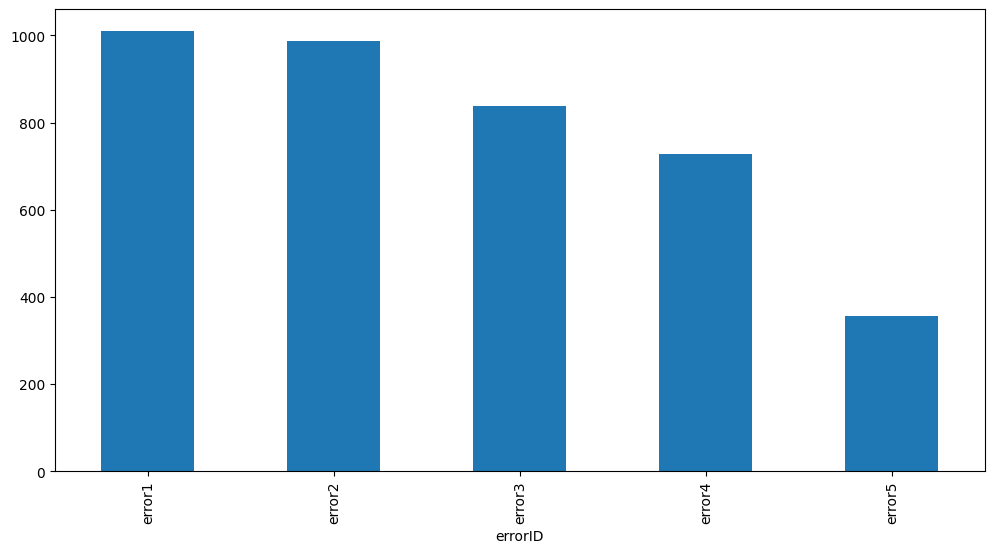

In [5]:
plt.figure(figsize=(12, 6))
errors["errorID"].value_counts().plot(kind="bar")
errors["errorID"].value_counts()

In [6]:
maint.head()

,datetime,machineID,comp
0,2014-06-01 06:00:00,1,comp2
1,2014-07-16 06:00:00,1,comp4
2,2014-07-31 06:00:00,1,comp3
3,2014-12-13 06:00:00,1,comp1
4,2015-01-05 06:00:00,1,comp4


comp
comp2    863
comp4    811
comp3    808
comp1    804
Name: count, dtype: int64

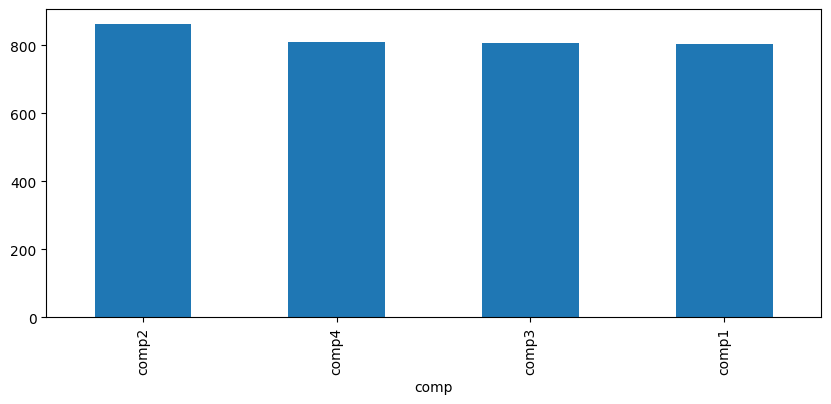

In [7]:
plt.figure(figsize=(10, 4))
maint["comp"].value_counts().plot(kind="bar")
maint["comp"].value_counts()

In [8]:
machines.head()

,machineID,model,age
0,1,model3,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model3,2


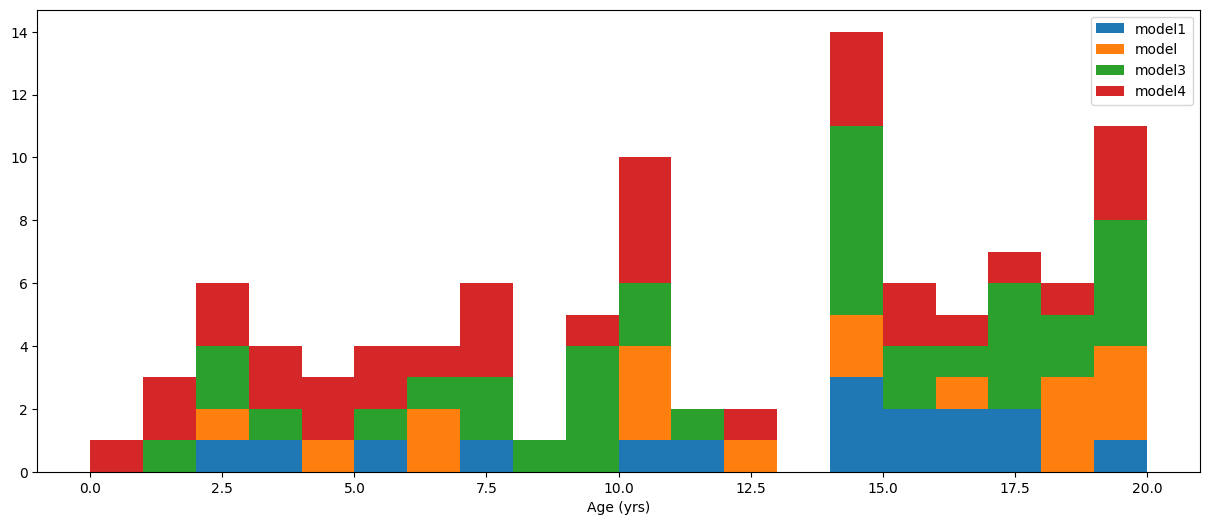

In [9]:
plt.figure(figsize=(15, 6))
_, bins, _ = plt.hist([machines.loc[machines["model"] == "model1", "age"],
                       machines.loc[machines["model"] == "model2", "age"],
                       machines.loc[machines["model"] == "model3", "age"],
                       machines.loc[machines["model"] == "model4", "age"]],
                       20, stacked=True, label=["model1", "model", "model3", "model4"])
plt.xlabel("Age (yrs)")
plt.legend()

In [10]:
failures.head()

,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4


failure
comp2    259
comp1    192
comp4    179
comp3    131
Name: count, dtype: int64

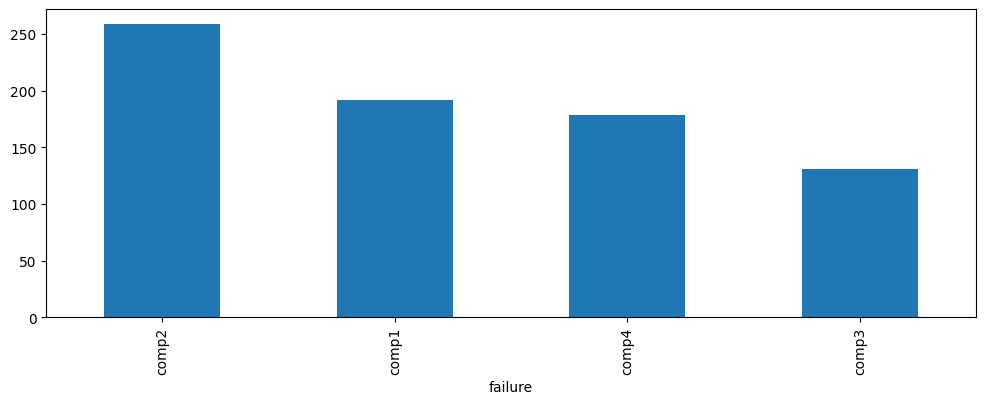

In [11]:
plt.figure(figsize=(12, 4))
failures["failure"].value_counts().plot(kind="bar")
failures["failure"].value_counts()

## Шаг 2: Feature Engineering

Примечание: 

Этот датасет не содержит пропусков, поэтому этап импутации (LSTM encoder-decoder) можно опустить. Временные окна есть.

2.1. Скользящие средние и STD (3h и 24h)

In [12]:
# Сводка по машинам и времени
telemetry["datetime"] = pd.to_datetime(telemetry["datetime"])

# Усредняем по машинам и времени с шагом 3 часа
telemetry["datetime_3h"] = telemetry["datetime"].dt.floor("3H")

# Список признаков
fields = ["volt", "rotate", "pressure", "vibration"]

# 3H признаки
temp_mean_3h, temp_std_3h = [], []
for col in fields:
    pt = pd.pivot_table(telemetry, index="datetime", columns="machineID", values=col)
    # Ресемплируем до 3-часовых интервалов
    resampled = pt.resample('3H', closed='left', label='right')
    temp_mean_3h.append(resampled.mean().unstack())
    temp_std_3h.append(resampled.std().unstack())

telemetry_mean_3h = pd.concat(temp_mean_3h, axis=1)
telemetry_mean_3h.columns = [f"{col}mean_3h" for col in fields]

telemetry_sd_3h = pd.concat(temp_std_3h, axis=1)
telemetry_sd_3h.columns = [f"{col}sd_3h" for col in fields]

# Сбрасываем индекс, чтобы machineID и datetime стали колонками
telemetry_mean_3h = telemetry_mean_3h.reset_index()
telemetry_sd_3h = telemetry_sd_3h.reset_index()

# 24H признаки
temp_mean_24h, temp_std_24h = [], []
for col in fields:
    pt = pd.pivot_table(telemetry, index="datetime", columns="machineID", values=col)
    # Скользящее окно 24 часа (24 записи при часовой частоте)
    rolling_mean = pt.rolling(window=24, min_periods=1).mean()
    rolling_std = pt.rolling(window=24, min_periods=1).std()
    # Ресемплируем каждые 3 часа, берём первое значение окна
    temp_mean_24h.append(rolling_mean.resample("3H", closed="left", label="right").first().unstack())
    temp_std_24h.append(rolling_std.resample("3H", closed="left", label="right").first().unstack())

telemetry_mean_24h = pd.concat(temp_mean_24h, axis=1)
telemetry_mean_24h.columns = [f"{col}mean_24h" for col in fields]
telemetry_mean_24h = telemetry_mean_24h.reset_index()

telemetry_sd_24h = pd.concat(temp_std_24h, axis=1)
telemetry_sd_24h.columns = [f"{col}sd_24h" for col in fields]
telemetry_sd_24h = telemetry_sd_24h.reset_index()

# Удаляем строки, где 24h статистика не определена (NaN)
telemetry_mean_24h = telemetry_mean_24h.dropna(subset=[f"{fields[0]}mean_24h"])
telemetry_sd_24h = telemetry_sd_24h.dropna(subset=[f"{fields[0]}sd_24h"])

In [13]:
# Объединение всех признаков
# Берём machineID и datetime из telemetry_mean_3h
telemetry_feat = telemetry_mean_3h.copy()

# Добавляем остальные признаки 
for df in [telemetry_sd_3h, telemetry_mean_24h, telemetry_sd_24h]:
    # Исключаем колонки machineID и datetime при слиянии
    telemetry_feat = telemetry_feat.merge(df, on=["machineID", "datetime"], how="inner")

# Удаляем оставшиеся NaN 
telemetry_feat = telemetry_feat.dropna()

telemetry_feat.describe()

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,voltmean_24h,rotatemean_24h,pressuremean_24h,vibrationmean_24h,voltsd_24h,rotatesd_24h,pressuresd_24h,vibrationsd_24h
count,292000.000000,292000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000
mean,50.500000,2015-07-02 19:30:00.000000256,170.777300,446.605807,100.858510,40.384920,13.299090,44.456338,8.885976,4.441164,170.777432,446.604867,100.858878,40.384597,14.915961,49.943867,10.046078,5.001976
min,1.000000,2015-01-01 09:00:00,125.532506,211.811184,72.118639,26.569635,0.025509,0.078991,0.027417,0.015278,136.878588,266.010419,76.005332,22.973289,0.029992,0.750946,0.156141,0.016414
25%,25.750000,2015-04-02 14:15:00,164.449510,427.560977,96.238546,38.147765,8.027455,26.903705,5.370581,2.684790,168.069944,441.536242,98.667448,39.353089,13.355848,44.660097,8.922924,4.459796
50%,50.500000,2015-07-02 19:30:00,170.434378,448.382261,100.234191,40.145837,12.495658,41.794719,8.346020,4.173955,170.212055,449.210337,100.098223,40.072764,14.852462,49.611770,9.921189,4.958575
75%,75.250000,2015-10-02 00:45:00,176.611778,468.448505,104.406557,42.227559,17.688490,59.104130,11.790303,5.900106,172.463410,456.371174,101.613838,40.834217,16.394635,54.825130,10.981148,5.485249
max,100.000000,2016-01-01 06:00:00,241.420717,586.682904,162.309656,69.311324,58.444332,179.903039,35.659369,18.305595,223.853296,576.923563,153.422157,61.932124,50.025809,161.679341,28.901987,13.203534
std,28.866119,NaN,9.500846,33.130042,7.414517,3.478823,6.965914,23.216712,4.656211,2.320302,4.736335,18.113897,4.751079,2.065360,2.271532,7.724405,1.720314,0.803358


In [14]:
telemetry_feat.head()

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,voltmean_24h,rotatemean_24h,pressuremean_24h,vibrationmean_24h,voltsd_24h,rotatesd_24h,pressuresd_24h,vibrationsd_24h
0,1,2015-01-01 09:00:00,170.028993,449.533798,94.592122,40.893502,6.721032,67.849599,18.934956,5.874970,176.217853,418.504078,113.077935,45.087686,9.431836,11.141591,12.457390,1.183494
1,1,2015-01-01 12:00:00,164.192565,403.949857,105.687417,34.255891,7.596570,50.120452,8.555032,7.662229,168.137453,423.687682,98.256232,40.950662,6.665324,75.770259,17.109194,4.798255
2,1,2015-01-01 15:00:00,168.134445,435.781707,107.793709,41.239405,10.124584,55.084734,5.909721,5.169304,165.602958,437.074655,101.799186,38.314585,7.663161,60.321814,13.926919,6.776542
3,1,2015-01-01 18:00:00,165.514453,430.472823,101.703289,40.373739,4.673269,42.047278,4.554047,2.106108,167.628643,432.864675,102.906797,38.906813,7.201655,52.122115,11.734582,6.091345
4,1,2015-01-01 21:00:00,168.809347,437.111120,90.911060,41.738542,14.752132,47.048609,4.244158,2.207884,165.920374,434.606729,101.180158,39.568936,7.567359,50.433677,11.284286,5.550047


2.2. Ошибки (подсчёт за 24h)

In [15]:
# Убедимся, что у нас есть machineID и datetime
errors["datetime"] = pd.to_datetime(errors["datetime"])
errors["datetime_3h"] = errors["datetime"].dt.floor("3H")

# Преобразуем errorID в числовые метки
errors["errorID"] = errors["errorID"].str.replace("error", "").astype(int)

# Создаём one-hot кодирование
error_dummies = pd.get_dummies(errors, columns=["errorID"], prefix="error")

# Группируем по machineID и 3-часовому времени, суммируя только числовые колонки (ошибки)
# Исключаем исходные нечисловые колонки (datetime, errorID)
id_cols = ["machineID", "datetime_3h"]
error_cols = [col for col in error_dummies.columns if col.startswith("error_")]

# Агрегируем по machineID и усреднённому времени
error_grouped = error_dummies.groupby(id_cols)[error_cols].sum().reset_index()

# Создаём 24H скользящее окно (8 окон по 3 ч)
# Для этого сначала сделаем pivot, чтобы применить rolling
temp = []
for col in error_cols:
    # Поворачиваем таблицу: строки = datetime_3h, колонки = machineID
    pt = pd.pivot_table(
        error_grouped,
        index="datetime_3h",
        columns="machineID",
        values=col,
        fill_value=0
    )
    # Скользящая сумма за 24 часа 
    rolling_sum = pt.rolling(window=8, min_periods=1).sum()
    # Ресемплируем каждые 3 часа 
    # Берём первое значение (оно же единственное) в каждом 3H интервале
    resampled = rolling_sum.resample("3H", closed="left", label="right").first()
    # Возвращаем в длинный формат
    temp.append(resampled.unstack())

# Объединяем все типы ошибок
error_count = pd.concat(temp, axis=1)
error_count.columns = [f"error{i}count" for i in range(1, 6)]

# Сбрасываем индекс, чтобы machineID и datetime стали колонками
error_count = error_count.reset_index()
error_count.rename(columns={"datetime_3h": "datetime"}, inplace=True)

# Удаляем строки, где нет данных 
error_count = error_count.dropna()

error_count.describe()

,machineID,datetime,error1count,error2count,error3count,error4count,error5count
count,195400.000000,195400,195400.000000,195400.000000,195400.000000,195400.000000,195400.000000
mean,50.500000,2015-07-02 11:45:32.241555712,0.041351,0.040409,0.034186,0.029724,0.014575
min,1.000000,2015-01-01 09:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.750000,2015-03-31 15:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
50%,50.500000,2015-07-02 19:30:00,0.000000,0.000000,0.000000,0.000000,0.000000
75%,75.250000,2015-10-01 21:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
max,100.000000,2016-01-01 06:00:00,2.000000,3.000000,2.000000,2.000000,2.000000
std,28.866144,NaN,0.202971,0.200702,0.184835,0.171951,0.120823


In [16]:
error_count.head()

,machineID,datetime,error1count,error2count,error3count,error4count,error5count
0,1,2015-01-01 09:00:00,0.0,0.0,0.0,0.0,0.0
1,1,2015-01-01 12:00:00,0.0,0.0,0.0,0.0,0.0
2,1,2015-01-01 15:00:00,0.0,0.0,0.0,0.0,0.0
4,1,2015-01-01 21:00:00,0.0,0.0,0.0,0.0,0.0
6,1,2015-01-02 03:00:00,0.0,0.0,0.0,0.0,0.0


2.3. Дни с последней замены компонента

In [17]:
# Подготовка maint
comp_rep = pd.get_dummies(maint.set_index("datetime")).reset_index()
comp_rep.columns = ["datetime", "machineID", "comp1", "comp2", "comp3", "comp4"]

# Агрегируем по machineID и datetime
comp_rep  = comp_rep.groupby(["machineID", "datetime"]).sum().reset_index()

# Добавляем временные точки, где не было замен
comp_rep = telemetry[["datetime", "machineID"]].merge(comp_rep,
                                                      on=["datetime", "machineID"],
                                                      how="outer").fillna(0).sort_values(by=["machineID", "datetime"])  # Сортируем по машине и времени 

# Вычисляем дни с последней замены для каждого компонента
comp_cols = ["comp1", "comp2", "comp3", "comp4"]
for comp in comp_cols:
    # Создаём бинарный флаг: была ли замена?
    comp_rep.loc[comp_rep[comp] < 1, comp] = None
    comp_rep.loc[-comp_rep[comp].isnull(), comp] = comp_rep.loc[-comp_rep[comp].isnull(), "datetime"]
    
    # Заполняем с датой последней замены компонента (по машинам)
    comp_rep[comp] = comp_rep[comp].fillna(method="ffill")

# Удаляем данные до 2015 года
comp_rep = comp_rep[comp_rep["datetime"] >= pd.to_datetime("2015-01-01")].reset_index(drop=True)
for comp in comp_cols:
    comp_rep[comp] = (comp_rep["datetime"] - comp_rep[comp]) / np.timedelta64(1, "D")

comp_rep.describe()

,datetime,machineID,comp1,comp2,comp3,comp4
count,876100,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000
mean,2015-07-02 18:00:00,50.500000,53.525185,51.540806,52.725962,53.834191
min,2015-01-01 06:00:00,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2015-04-02 12:00:00,25.750000,13.291667,12.125000,13.125000,13.000000
50%,2015-07-02 18:00:00,50.500000,32.791667,29.666667,32.291667,32.500000
75%,2015-10-02 00:00:00,75.250000,68.708333,66.541667,67.333333,70.458333
max,2016-01-01 06:00:00,100.000000,491.958333,348.958333,370.958333,394.958333
std,NaN,28.866087,62.491679,59.269254,58.873114,59.707978


In [18]:
comp_rep.head()

,datetime,machineID,comp1,comp2,comp3,comp4
0,2015-01-01 06:00:00,1,19.000000,214.000000,154.000000,169.000000
1,2015-01-01 07:00:00,1,19.041667,214.041667,154.041667,169.041667
2,2015-01-01 08:00:00,1,19.083333,214.083333,154.083333,169.083333
3,2015-01-01 09:00:00,1,19.125000,214.125000,154.125000,169.125000
4,2015-01-01 10:00:00,1,19.166667,214.166667,154.166667,169.166667


2.4. Объединение всех признаков

In [19]:
# Слияние
final_feat = telemetry_feat.merge(error_count, on=["machineID", "datetime"], how="left")
final_feat = final_feat.merge(comp_rep, on=["machineID", "datetime"], how="left")
final_feat = final_feat.merge(machines, on="machineID", how="left")

# Заполнение NaN
final_feat = final_feat.fillna(0)
final_feat.describe()

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,...,error1count,error2count,error3count,error4count,error5count,comp1,comp2,comp3,comp4,age
count,292000.000000,292000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,...,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000
mean,50.500000,2015-07-02 19:30:00.000000256,170.777300,446.605807,100.858510,40.384920,13.299090,44.456338,8.885976,4.441164,...,0.027671,0.027041,0.022877,0.019890,0.009753,53.464473,51.475866,52.660493,53.769068,11.330000
min,1.000000,2015-01-01 09:00:00,125.532506,211.811184,72.118639,26.569635,0.025509,0.078991,0.027417,0.015278,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.750000,2015-04-02 14:15:00,164.449510,427.560977,96.238546,38.147765,8.027455,26.903705,5.370581,2.684790,...,0.000000,0.000000,0.000000,0.000000,0.000000,13.250000,12.125000,13.125000,13.000000,6.750000
50%,50.500000,2015-07-02 19:30:00,170.434378,448.382261,100.234191,40.145837,12.495658,41.794719,8.346020,4.173955,...,0.000000,0.000000,0.000000,0.000000,0.000000,32.750000,29.625000,32.250000,32.500000,12.000000
75%,75.250000,2015-10-02 00:45:00,176.611778,468.448505,104.406557,42.227559,17.688490,59.104130,11.790303,5.900106,...,0.000000,0.000000,0.000000,0.000000,0.000000,68.625000,66.500000,67.250000,70.375000,16.000000
max,100.000000,2016-01-01 06:00:00,241.420717,586.682904,162.309656,69.311324,58.444332,179.903039,35.659369,18.305595,...,2.000000,3.000000,2.000000,2.000000,2.000000,491.875000,348.875000,370.875000,394.875000,20.000000
std,28.866119,NaN,9.500846,33.130042,7.414517,3.478823,6.965914,23.216712,4.656211,2.320302,...,0.167173,0.165278,0.152054,0.141355,0.099075,62.479594,59.251179,58.856793,59.692723,5.827625


In [20]:
final_feat.head()

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,...,error2count,error3count,error4count,error5count,comp1,comp2,comp3,comp4,model,age
0,1,2015-01-01 09:00:00,170.028993,449.533798,94.592122,40.893502,6.721032,67.849599,18.934956,5.874970,...,0.0,0.0,0.0,0.0,19.125,214.125,154.125,169.125,model3,18
1,1,2015-01-01 12:00:00,164.192565,403.949857,105.687417,34.255891,7.596570,50.120452,8.555032,7.662229,...,0.0,0.0,0.0,0.0,19.250,214.250,154.250,169.250,model3,18
2,1,2015-01-01 15:00:00,168.134445,435.781707,107.793709,41.239405,10.124584,55.084734,5.909721,5.169304,...,0.0,0.0,0.0,0.0,19.375,214.375,154.375,169.375,model3,18
3,1,2015-01-01 18:00:00,165.514453,430.472823,101.703289,40.373739,4.673269,42.047278,4.554047,2.106108,...,0.0,0.0,0.0,0.0,19.500,214.500,154.500,169.500,model3,18
4,1,2015-01-01 21:00:00,168.809347,437.111120,90.911060,41.738542,14.752132,47.048609,4.244158,2.207884,...,0.0,0.0,0.0,0.0,19.625,214.625,154.625,169.625,model3,18


2.5. Присоединение отказов 

In [21]:
# Убедимся, что failures имеет нужные колонки
failures = failures[["datetime", "machineID", "failure"]].copy()

# Объединяем с признаками
labeled_features = final_feat.merge(failures, on=["datetime", "machineID"], how="left")

# Заполняем назад до 7 временных шагов (24H)
labeled_features["failure"] = labeled_features.groupby("machineID")["failure"].fillna(method="bfill", limit=7)

# Всё остальное "none"
labeled_features["failure"] = labeled_features["failure"].fillna("none")

labeled_features[["datetime", "machineID", "failure"]].head(10)

,datetime,machineID,failure
0,2015-01-01 09:00:00,1,none
1,2015-01-01 12:00:00,1,none
2,2015-01-01 15:00:00,1,none
3,2015-01-01 18:00:00,1,none
4,2015-01-01 21:00:00,1,none
5,2015-01-02 00:00:00,1,none
6,2015-01-02 03:00:00,1,none
7,2015-01-02 06:00:00,1,none
8,2015-01-02 09:00:00,1,none
9,2015-01-02 12:00:00,1,none


## Шаг 3: Построение бинарной метки (за 24h до отказа)

In [22]:
# Создание столбца failure 
labeled_features["failure"] = (labeled_features["failure"] != "none").astype(int)

# Список колонок-признаков
feature_cols = [col for col in labeled_features.columns if col not in ["datetime", "machineID", "failure", "label"]]

## Шаг 4: Временной сплит

Примечание (временные ряды): 

Данные обладают **внутренней хронологической зависимостью**: будущее зависит от прошлого, но прошлое не зависит от будущего.

In [23]:
# Дата разделения
last_train_date = pd.to_datetime("2015-08-01 01:00:00")

train_data = labeled_features[labeled_features['datetime'] < last_train_date]
val_data = labeled_features[labeled_features['datetime'] >= last_train_date]

# Признаки и метки
X_train = train_data[feature_cols].values  # (N_train, n_features)
y_train = train_data["label"].values       # (N_train,)

X_val = val_data[feature_cols].values    # (N_val, n_features)
y_val = val_data["label"].values         # (N_val,)

# Выравниваем колонки 
X_val = X_val.reindex(columns=X_train.columns, fill_value=0)

print(f"Train shape: {X_train.shape}, Val shape: {X_val.shape}")

KeyError: 'label'

## Шаг 5: Обучение модели

In [ ]:
# Обучение
model = GradientBoostingClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Прогноз
y_pred = model.predict(X_val)
y_score = model.predict_proba(X_val)[:, 1]